In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Load Dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
image_path = os.path.join("/content/gdrive/MyDrive/chestct/Lung Segmentation/CXR_png")
mask_path = os.path.join("/content/gdrive/MyDrive/chestct/Lung Segmentation/masks")
reading_path = os.path.join("/content/gdrive/MyDrive/chestct/Lung Segmentation/ClinicalReadings")

# Any results you write to the current directory are saved as output.

# Data Analysis

In [ ]:
images = os.listdir(image_path)
masks = os.listdir(mask_path)
readings = os.listdir(reading_path)
print('Total number of x-ray images:',len(images))
print('Total number of masks:',len(masks))
print('Total number of clinical readings:',len(readings))

Total number of x-ray images: 800
Total number of masks: 704
Total number of clinical readings: 800


In [ ]:
tb_positive = [image for image in images if image.split('.png')[0][-1]=='1']
tb_negative = [image for image in images if image.split('.png')[0][-1]=='0']
print('There are %d tuberculosis positive cases.' % len(tb_positive))
print('There are %d tuberculosis negative cases.' % len(tb_negative))

There are 394 tuberculosis positive cases.
There are 406 tuberculosis negative cases.


Image CHNCXR_0542_1.png is positive on tuberculosis.


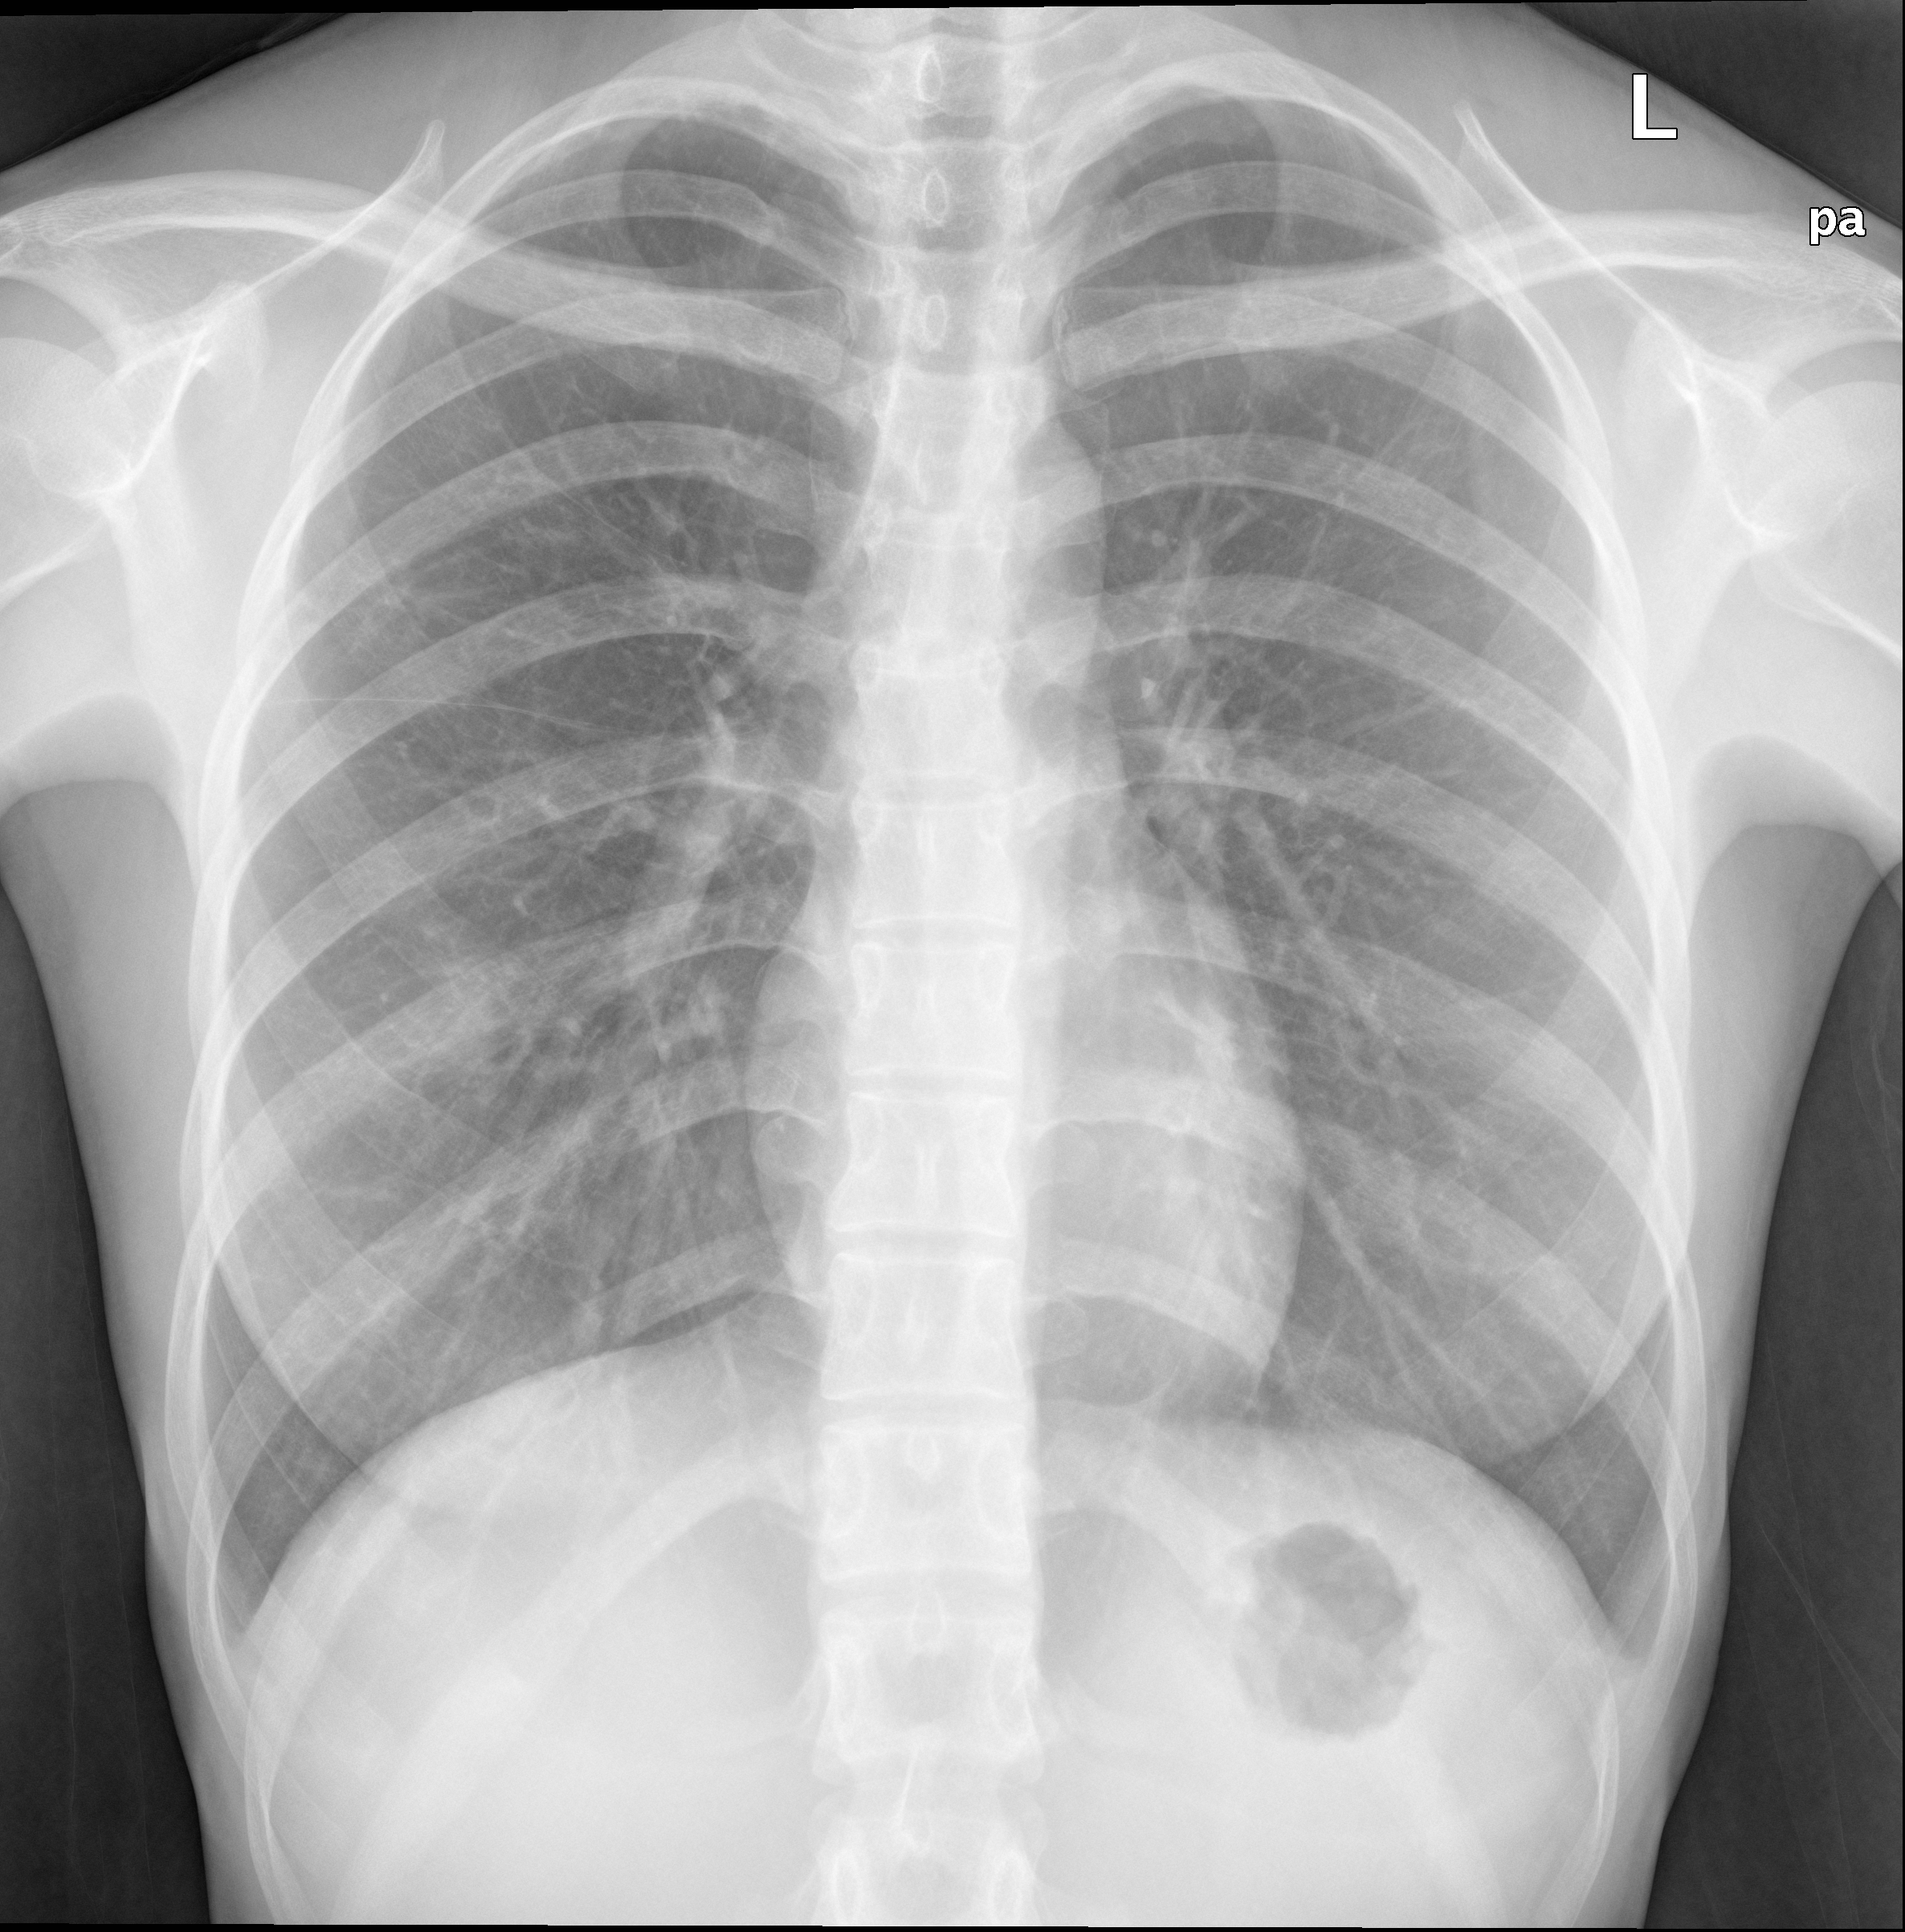

Image CHNCXR_0075_0.png is negative on tuberculosis.


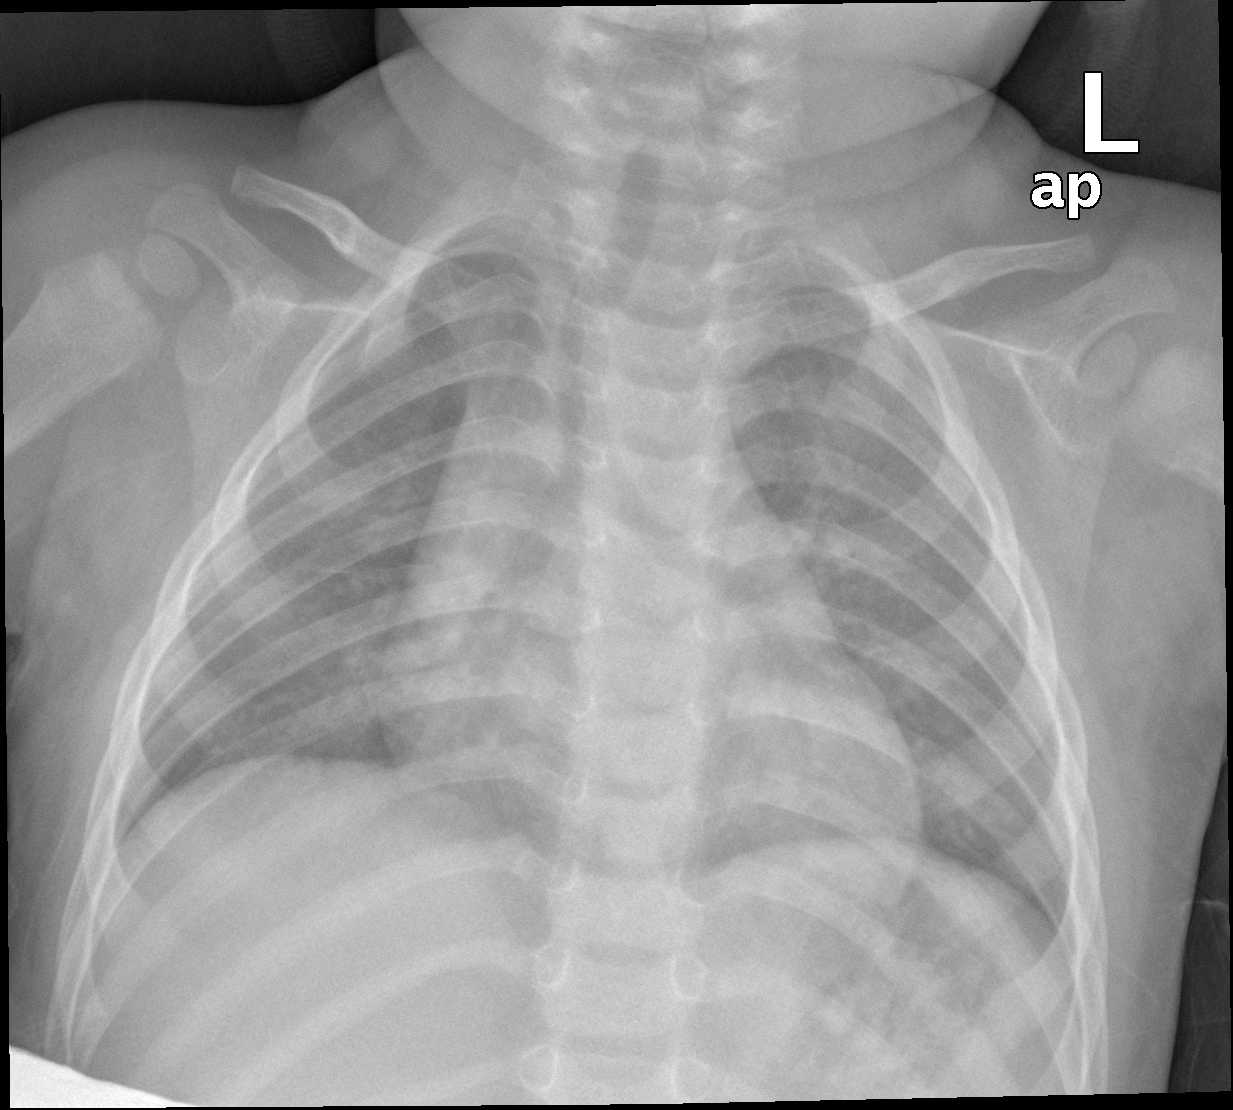

In [ ]:
from IPython.display import Image
pos_image = np.random.choice(tb_positive,1)
neg_image = np.random.choice(tb_negative,1)
print("Image %s is positive on tuberculosis." % pos_image[0])
display(Image(os.path.join("/content/gdrive/MyDrive/chestct/Lung Segmentation/CXR_png",pos_image[0]),width=256,height=256))
print("Image %s is negative on tuberculosis." % neg_image[0])
display(Image(os.path.join("/content/gdrive/MyDrive/chestct/Lung Segmentation/CXR_png",neg_image[0]),width=256,height=256))

In [ ]:
tb_state = [int(image.split('.png')[0][-1]) for image in images]
img_df = pd.DataFrame({'Image_name':images, 'TB_state': tb_state})
img_df['Path'] = img_df['Image_name'].map(lambda x: "/content/gdrive/MyDrive/chestct/Lung Segmentation/CXR_png/"+x)
img_df['Source'] = img_df['Image_name'].map(lambda x: x.split('_')[0])
img_df['Text_path'] = img_df['Image_name'].map(lambda x: "/content/gdrive/MyDrive/chestct/Lung Segmentation/ClinicalReadings/"+x.split('.png')[0]+'.txt')
img_df.head()

Image_name  TB_state  \
0  CHNCXR_0001_0.png         0   
1  CHNCXR_0002_0.png         0   
2  CHNCXR_0003_0.png         0   
3  CHNCXR_0004_0.png         0   
4  CHNCXR_0005_0.png         0   

                                                Path  Source  \
0  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
1  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
2  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
3  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
4  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   

                                           Text_path  
0  /content/gdrive/MyDrive/chestct/Lung Segmentat...  
1  /content/gdrive/MyDrive/chestct/Lung Segmentat...  
2  /content/gdrive/MyDrive/chestct/Lung Segmentat...  
3  /content/gdrive/MyDrive/chestct/Lung Segmentat...  
4  /content/gdrive/MyDrive/chestct/Lung Segmentat...

In [ ]:
ages=[]
genders=[]
descriptions=[]
for txt in img_df.Text_path.tolist():
    lines = [line for line in open(txt,'r')]
    if "Patient's Sex:" in lines[0]:
        gender = lines[0][lines[0].index("Patient's Sex:")+len("Patient's Sex:")+1]
        genders.append(gender)
        start = lines[1].index("Patient's Age:")
        length = len("Patient's Age:")
        age = int(lines[1][start+length+2:start+length+4])
        ages.append(age)
        description = ' '.join(lines[2:]).strip()
        descriptions.append(description)
    else:
        if "male" or "MALE" in lines[0]:
            gender = 'M'
            genders.append(gender)
        else:
            gender = 'F'
            genders.append(gender)
        if "yrs" in lines[0]:
            start = lines[0].index("yrs")
            age = int(lines[0][start-2:start])
            ages.append(age)
        elif "yr" in lines[0]:
            start = lines[0].index("yr")
            age = int(lines[0][start-2:start])
            ages.append(age)
        else:
            ages.append(np.NaN)
        description = ' '.join(lines[1:]).strip()
        descriptions.append(description)
            
img_df['Age'] = ages
img_df['Gender'] = genders
img_df['Description'] = descriptions
img_df.head()

Image_name  TB_state  \
0  CHNCXR_0001_0.png         0   
1  CHNCXR_0002_0.png         0   
2  CHNCXR_0003_0.png         0   
3  CHNCXR_0004_0.png         0   
4  CHNCXR_0005_0.png         0   

                                                Path  Source  \
0  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
1  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
2  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
3  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
4  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   

                                           Text_path   Age Gender Description  
0  /content/gdrive/MyDrive/chestct/Lung Segmentat...  45.0      M      normal  
1  /content/gdrive/MyDrive/chestct/Lung Segmentat...  63.0      M      normal  
2  /content/gdrive/MyDrive/chestct/Lung Segmentat...  48.0      M      normal  
3  /content/gdrive/MyDrive/chestct/Lung Segmentat...  58.0      M      normal  
4  /content/gdrive/MyDrive/chestct/Lung Segmentat...  28.0      M      normal

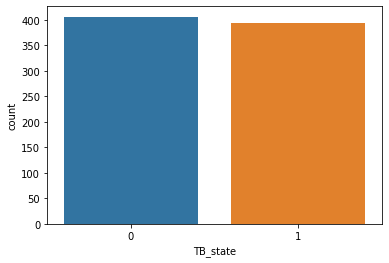

In [ ]:
sns.countplot(x='TB_state', data=img_df)


In [ ]:
img_df.groupby(by='Source')['Image_name'].count()


Source
CHNCXR    662
MCUCXR    138
Name: Image_name, dtype: int64

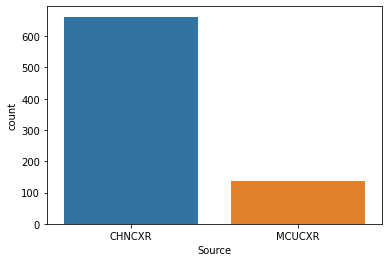

In [ ]:
sns.countplot(x='Source', data=img_df)


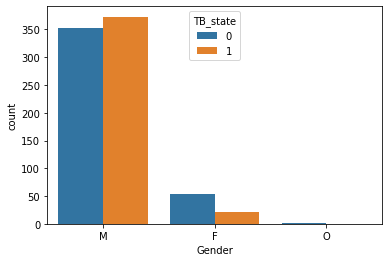

In [ ]:
sns.countplot(x='Gender', hue='TB_state', data=img_df)


In [ ]:
sum((img_df.Gender=='M'))


725

In [ ]:
sum((img_df.Gender=='F'))


74

In [ ]:
img_df[img_df.Gender=='O']


Image_name  TB_state  \
718  MCUCXR_0080_0.png         0   

                                                  Path  Source  \
718  /content/gdrive/MyDrive/chestct/Lung Segmentat...  MCUCXR   

                                             Text_path  Age Gender Description  
718  /content/gdrive/MyDrive/chestct/Lung Segmentat...  5.0      O      normal

In [ ]:
print('TB positive rate of male patients:',sum((img_df.Gender=='M') & (img_df.TB_state==1)) / sum(img_df.Gender=='M'))
print('TB positive rate of female patients:',sum((img_df.Gender=='F') & (img_df.TB_state==1)) / sum(img_df.Gender=='F'))

TB positive rate of male patients: 0.5144827586206897
TB positive rate of female patients: 0.28378378378378377


In [ ]:
img_df[img_df.Age.isnull()]


Image_name  TB_state  \
17   CHNCXR_0018_0.png         0   
114  CHNCXR_0115_0.png         0   
202  CHNCXR_0201_0.png         0   
203  CHNCXR_0202_0.png         0   

                                                  Path  Source  \
17   /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
114  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
202  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   
203  /content/gdrive/MyDrive/chestct/Lung Segmentat...  CHNCXR   

                                             Text_path  Age Gender Description  
17   /content/gdrive/MyDrive/chestct/Lung Segmentat...  NaN      M      normal  
114  /content/gdrive/MyDrive/chestct/Lung Segmentat...  NaN      M      normal  
202  /content/gdrive/MyDrive/chestct/Lung Segmentat...  NaN      M      normal  
203  /content/gdrive/MyDrive/chestct/Lung Segmentat...  NaN      M      normal

In [ ]:
null_age_imgs = img_df[img_df.Age.isnull()].Text_path
for txt in null_age_imgs:
    lines = [line for line in open(txt,'r')]
    print(lines)

['male 42\n', 'normal']
['male 16month\n', 'normal']
['male 16month\n', 'normal']
['female 64days\n', 'normal']


In [ ]:
img_df.ix[446,'Age']=1
img_df.ix[469,'Age']=0
img_df.ix[535,'Age']=1
img_df.ix[660,'Age']=42
img_df[img_df.Age.isnull()]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


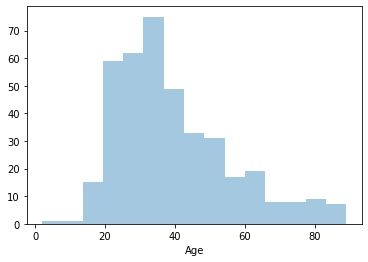

In [ ]:
sns.distplot(img_df[img_df.TB_state==1]['Age'], kde=False)


# Feature extraction(ResNet50)

In [ ]:
import time
start = time.time()

import numpy as np
from tensorflow.keras.applications import ResNet50, InceptionV3, InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

resnet_weights_path = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
#inceptionv3_weights_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#inceptionresnetv2_weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = ResNet50(weights='imagenet')
#base_model = InceptionResNetV2(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

image_size = 224
img_paths = img_df.Path.tolist()
features_array = np.zeros((800,2048))

for i, img_path in enumerate(img_paths):
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    features = features.reshape(2048,)
    features_array[i,:] = features
    
print('Running time: %.4f seconds' % (time.time()-start))

Running time: 157.2328 seconds


# Feature extraction(VGG16)

In [ ]:
import time
start = time.time()

import numpy as np
from tensorflow.keras.applications import ResNet50, InceptionV3, InceptionResNetV2, VGG19, VGG16,EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
#from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
#from tensorflow.python.keras.applications.inception_v3 import preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.python.keras.applications.inception_resnet_v2 import preprocess_input

#base_model = ResNet50(weights='imagenet')
#base_model = InceptionV3(weights='imagenet')
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

image_size = 224
img_paths = img_df.Path.tolist()
features_array = np.zeros((800, 25088))

for i, img_path in enumerate(img_paths):
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    features = features.reshape(25088,)
    features_array[i,:] = features
    
print('Running time: %.4f seconds' % (time.time()-start))

In [ ]:
features_array.shape


(800, 2048)

In [ ]:
df = pd.DataFrame(features_array)
df['Image_name'] = img_df.Image_name
df['TB_state'] = img_df.TB_state
df.head(2)

0         1         2         3         4         5         6  \
0  4.154006  1.295366  0.000000  0.327991  0.211735  0.075191  0.120558   
1  3.675618  2.107843  0.013082  0.887597  0.430665  0.396853  0.131854   

          7    8         9  ...      2040      2041      2042      2043  \
0  0.158660  0.0  0.071543  ...  0.324917  0.015839  1.148969  2.517698   
1  0.072968  0.0  0.043716  ...  1.249372  0.289437  1.245333  2.353930   

       2044      2045      2046      2047         Image_name  TB_state  
0  0.511620  0.208803  0.131006  0.252964  CHNCXR_0001_0.png         0  
1  0.645483  0.070587  0.346572  0.008636  CHNCXR_0002_0.png         0  

[2 rows x 2050 columns]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

X = df.drop(['Image_name', 'TB_state'], axis=1)
y = df.TB_state
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

# Feed extracted features into classifier

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

weight_path="{}_mlp1.h5".format('BEST')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='auto')

callbacks_list = [checkpoint, reduceLROnPlat]

In [ ]:
import keras 
import random
from keras.models import Sequential
from keras.layers import Dense
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
model = Sequential()
model.add(Dense(200, input_shape=(2048,), activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history=model.fit(Xtrain,ytrain, epochs=100, batch_size=8, verbose=1,validation_data=(Xtest, ytest), callbacks=callbacks_list)

# Results and Plots

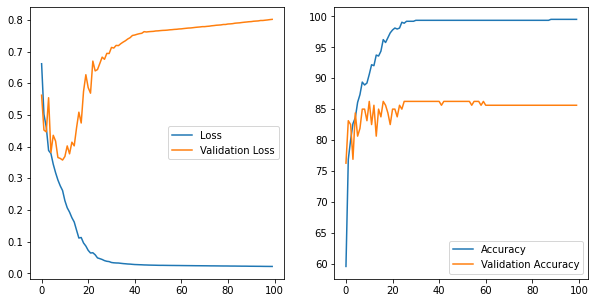

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

Text(0.5, 1.0, 'Confusion Matrix')

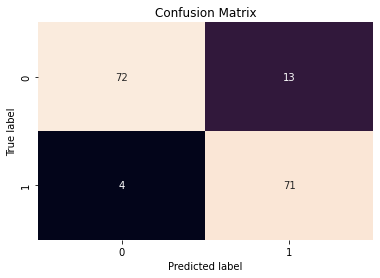

In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
model=load_model(r"/content/BEST_mlp1.h5", compile=False)
preds=model.predict(Xtest)
x=[]
z=[]
for i in range(160):
  x=preds[i]
  if x[0]>x[1]:
    x=0
  else:
    x=1
  z.append(x)
len(z)
cm = confusion_matrix(ytest,z)
sns.heatmap(cm, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
LABELS = [
    'Tuberculosis negative cases',
    'Tuberculosis positive cases',

]
print(classification_report(y_true = ytest, y_pred = z,target_names=LABELS))


                             precision    recall  f1-score   support

Tuberculosis negative cases       0.95      0.85      0.89        85
Tuberculosis positive cases       0.85      0.95      0.89        75

                   accuracy                           0.89       160
                  macro avg       0.90      0.90      0.89       160
               weighted avg       0.90      0.89      0.89       160



# feature vector is L2 normalized to unit length

In [ ]:
norms = np.linalg.norm(features_array, axis = 1, keepdims=True)
X_norm = features_array/norms
X_norm.shape

(800, 2048)

In [ ]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X_norm, y, test_size=0.2)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

weight_path="{}_mlp2.h5".format('BEST')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='auto')

callbacks_list = [checkpoint, reduceLROnPlat]

In [ ]:
import keras 
import random
from keras.models import Sequential
from keras.layers import Dense
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
model = Sequential()
model.add(Dense(200, input_shape=(2048,), activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history=model.fit(Xtrain2,ytrain2, epochs=100, batch_size=8, verbose=1,validation_data=(Xtest2, ytest2), callbacks=callbacks_list)

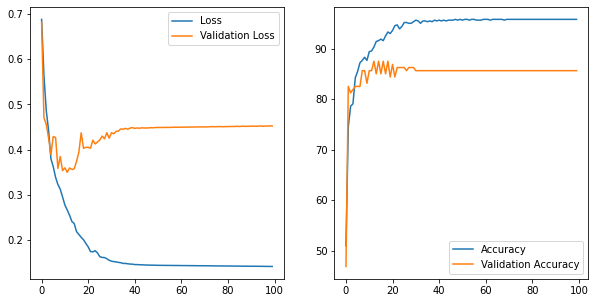

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

Text(0.5, 1.0, 'Confusion Matrix')

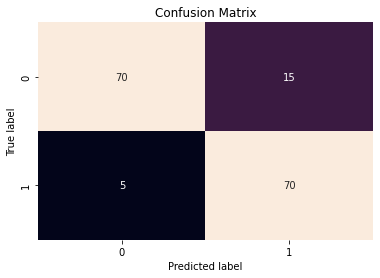

In [ ]:
from keras.models import load_model
model=load_model(r"/content/BEST_mlp2.h5", compile=False)
preds=model.predict(Xtest2)
x=[]
z=[]
for i in range(160):
  x=preds[i]
  if x[0]>x[1]:
    x=0
  else:
    x=1
  z.append(x)
len(z)
cm = confusion_matrix(ytest2,z)
sns.heatmap(cm, annot=True, cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest2, z))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        85
           1       0.82      0.93      0.87        75

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.87       160
weighted avg       0.88      0.88      0.87       160

